# Experimental Analysis

### Imports

In [1]:
from datasets import load_dataset 
import CodeSyntaxConcept.utils as utils
from CodeSyntaxConcept.tokenizer import CodeTokenizer
from CodeSyntaxConcept.parser import TreeSitterParser
import pandas as pd
import seaborn as sns
from statistics import mean, median, stdev
from scipy import stats


/home/svelascodimate/miniconda3/envs/code-syntax-concept/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters

In [2]:
#Checkpoint is irrelevant in this analysis, we use it to instantiate CodeTokenizer
checkpoint = "himanshu-dutta/pycoder-gpt2"   
number_of_samples = 15000
language = "python"
save_path_parent_node_types = "output/parent_node_types.csv"

### Load Samples

In [3]:
test_set = load_dataset("code_search_net", split='test')
test_set = test_set.filter(lambda sample: True if 
                sample['language']== language 
            else False, num_proc=1)
test_set = utils.get_random_sub_set_test_set(test_set, number_of_samples)

No config specified, defaulting to: code_search_net/all
Found cached dataset code_search_net (/home/svelascodimate/.cache/huggingface/datasets/code_search_net/all/1.0.0/80a244ab541c6b2125350b764dc5c2b715f65f00de7a56107a28915fac173a27)
Loading cached processed dataset at /home/svelascodimate/.cache/huggingface/datasets/code_search_net/all/1.0.0/80a244ab541c6b2125350b764dc5c2b715f65f00de7a56107a28915fac173a27/cache-3fbe88ea46cf0b42.arrow


### Mapping Concepts

In [4]:
parser = TreeSitterParser(CodeTokenizer.from_pretrained(checkpoint,language))
test_set_node_counts = [()]*len(parser.tokenizer.node_types)

parent_node_types = set()

for sample in test_set:
    tree = parser.tokenizer.parser.parse(bytes(sample['whole_func_string'], "utf8"))

    sample_parent_nodes = []
    utils.find_parent_nodes(tree.root_node, sample_parent_nodes)
    parent_node_types.update([parent_node.type for parent_node in sample_parent_nodes])

    for ast_element in parser.tokenizer.node_types:
        ast_element_ocurrences = []
        utils.find_nodes(tree.root_node, ast_element, ast_element_ocurrences)
        test_set_node_counts[parser.tokenizer.node_types.index(ast_element)] = test_set_node_counts[parser.tokenizer.node_types.index(ast_element)] + tuple([len(ast_element_ocurrences)])

In [5]:
parent_node_types_dataframe = pd.DataFrame([], columns=['parent_type'])
for parent_node_type in parent_node_types:
    parent_node_types_dataframe.loc[len(parent_node_types_dataframe.index)] = parent_node_type
parent_node_types_dataframe.to_csv(save_path_parent_node_types)

### Counts Dataframe

In [6]:
node_counts_dataframe = pd.DataFrame([], columns=['ast_element', 'counts', 'leaf_node'])
for node_id, node_counts in enumerate(test_set_node_counts):
    node_counts_dataframe.loc[len(node_counts_dataframe.index)] = [parser.tokenizer.node_types[node_id], node_counts, False if parser.tokenizer.node_types[node_id] in parent_node_types else True]

node_counts_dataframe.head()

,ast_element,counts,leaf_node
0,as_pattern,"(0, 0, 0, 7, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, ...",False
1,and,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
2,except,"(0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, ...",True
3,~,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
4,__future__,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True


### Statisctics 

In [7]:
#node_counts_dataframe = node_counts_dataframe.drop('Unnamed: 0', axis=1)
node_counts_dataframe

,ast_element,counts,leaf_node
0,as_pattern,"(0, 0, 0, 7, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, ...",False
1,and,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
2,except,"(0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, ...",True
3,~,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
4,__future__,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
...,...,...,...
191,exec_statement,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
192,format_expression,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
193,generator_expression,"(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
194,case_pattern,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True


In [8]:
node_counts_dataframe['average'] = node_counts_dataframe['counts'].map(lambda counts: mean(counts))
node_counts_dataframe['median'] = node_counts_dataframe['counts'].map(lambda counts: median(counts))
node_counts_dataframe['stdev'] = node_counts_dataframe['counts'].map(lambda counts: stdev(counts))

median_absolute_deviation = []
for ast_counts in node_counts_dataframe['counts']:
    counts_median = median(ast_counts)
    median_absolute_deviation.append(median([abs(ast_count - counts_median) for ast_count in ast_counts]))
node_counts_dataframe['mad'] = median_absolute_deviation

node_counts_dataframe.head()

,ast_element,counts,leaf_node,average,median,stdev,mad
0,as_pattern,"(0, 0, 0, 7, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, ...",False,0.095267,0.0,0.454244,0.0
1,and,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.223067,0.0,0.795079,0.0
2,except,"(0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, ...",True,0.183333,0.0,0.622908,0.0
3,~,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.011333,0.0,0.216352,0.0
4,__future__,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.000000,0.0,0.000000,0.0


### Visualization - LEAF NODES

In [9]:
leaf_nodes_dataframe = node_counts_dataframe[node_counts_dataframe['leaf_node'] == True] 

,ast_element,counts,leaf_node,average,median,stdev,mad
65,identifier,"(9, 23, 20, 153, 98, 62, 109, 13, 82, 13, 28, ...",True,40.035733,26.0,45.818731,12.0
22,"""","(2, 10, 2, 112, 56, 2, 28, 2, 32, 2, 4, 8, 2, ...",True,10.848800,6.0,19.297733,4.0
40,.,"(3, 9, 5, 44, 23, 3, 23, 0, 22, 1, 7, 3, 4, 5,...",True,9.217133,5.0,12.704580,3.0
117,),"(2, 3, 3, 59, 28, 5, 25, 3, 22, 4, 7, 5, 7, 7,...",True,9.025933,6.0,10.455315,3.0
150,(,"(2, 3, 3, 59, 28, 5, 25, 3, 22, 4, 7, 5, 7, 7,...",True,9.025933,6.0,10.455315,3.0


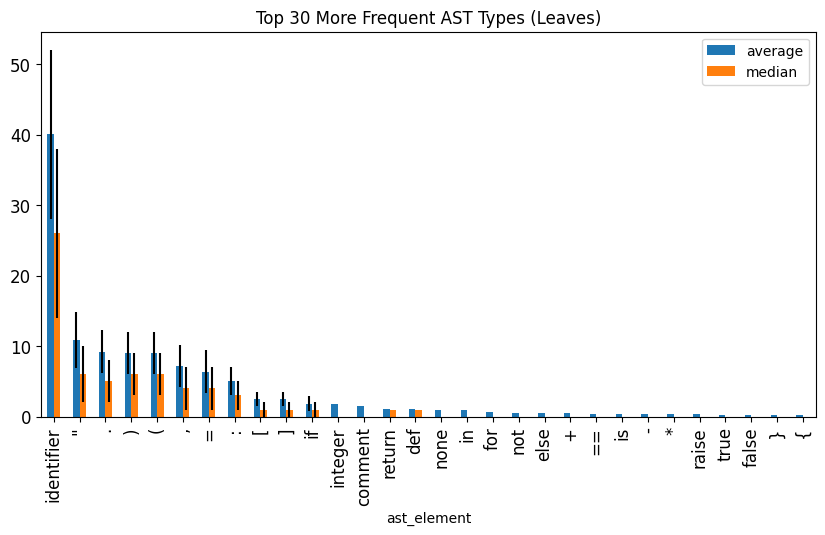

In [10]:
top_10 = leaf_nodes_dataframe.sort_values(by=['average'], ascending=False).head(30)
top_10.plot(x='ast_element',y=['average','median'] ,yerr='mad' ,kind='bar',fontsize=12, title='Top 30 More Frequent AST Types (Leaves)', figsize=(10,5))
top_10.head()

<AxesSubplot: title={'center': 'Top 30 Less Frequent Concepts (Leaves)'}, xlabel='ast_element'>

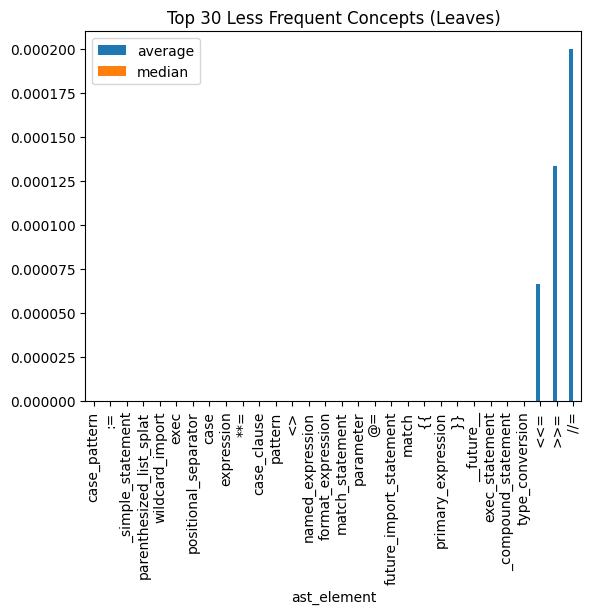

In [11]:
bottom_30 = leaf_nodes_dataframe.sort_values(by=['average'], ascending=True).head(30)
bottom_30.plot(x='ast_element',y=['average','median'] ,yerr='mad', kind='bar', title='Top 30 Less Frequent Concepts (Leaves)')

### Visualization - PARENT NODES

In [12]:
parent_nodes_dataframe = node_counts_dataframe[node_counts_dataframe['leaf_node'] == False] 

<AxesSubplot: title={'center': 'Top 30 More Frequent AST Types (Parents)'}, xlabel='ast_element'>

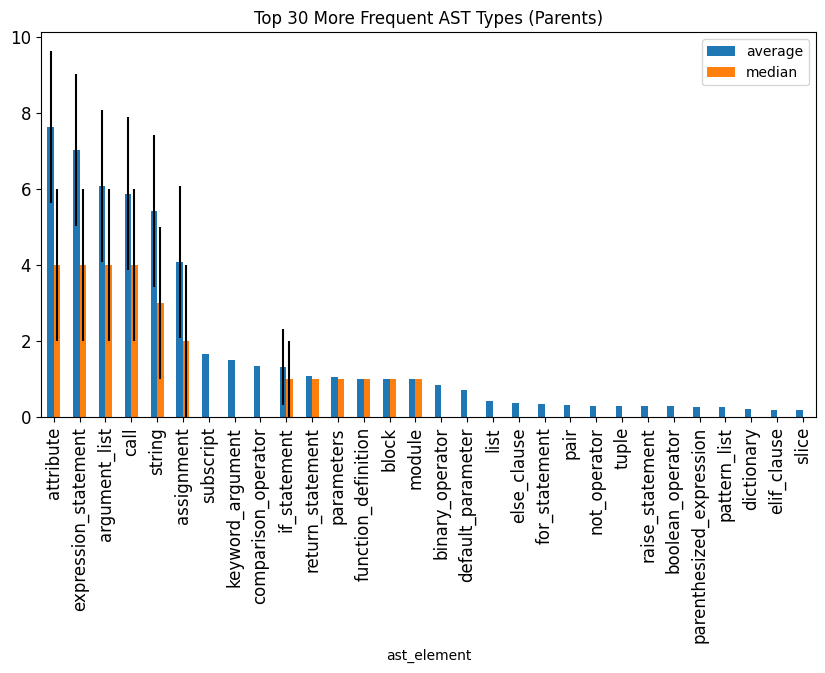

In [13]:
top_10 = parent_nodes_dataframe.sort_values(by=['average'], ascending=False).head(30)
top_10.plot(x='ast_element',y=['average','median'] ,yerr='mad', kind='bar',fontsize=12, title='Top 30 More Frequent AST Types (Parents)', figsize=(10,5))

<AxesSubplot: title={'center': 'Top 30 Less Frequent Concepts (Parents)'}, xlabel='ast_element'>

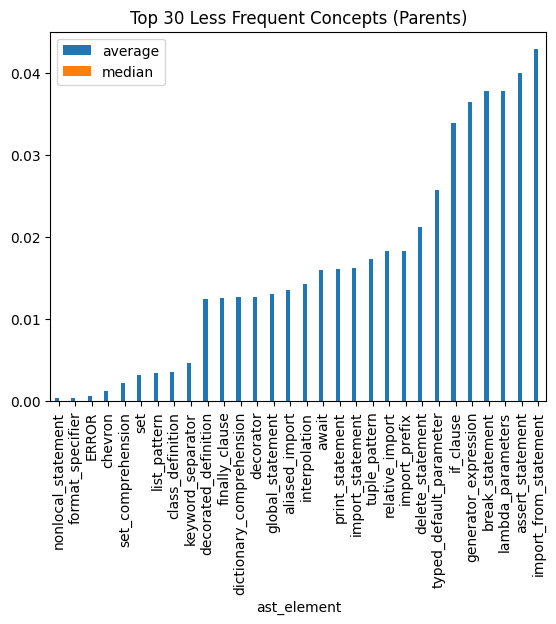

In [14]:
bottom_30 = parent_nodes_dataframe.sort_values(by=['average'], ascending=True).head(30)
bottom_30.plot(x='ast_element',y=['average','median'] ,yerr='mad', kind='bar', title='Top 30 Less Frequent Concepts (Parents)')